In [12]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

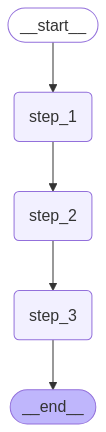

In [13]:
class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State):
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    print("--Node 2--")
    return state

def step_3(state: State):
    print("---Node 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_input = {"input": "hello LangGraph"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config=thread_config, stream_mode="values"):
    print(event)

{'input': 'hello LangGraph'}
---Step 1---
{'input': 'hello LangGraph'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello LangGraph', resumable=False, ns=None),)}


In [15]:
state =graph.get_state(thread_config)
print(state.next)

('step_2',)


In [16]:
print(state.tasks)

(PregelTask(id='8968f146-d612-813e-d697-c2d4c269affc', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello LangGraph', resumable=False, ns=None),), state=None, result=None),)


In [17]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello LangGraph'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello LangGraph', resumable=False, ns=None),)}


In [18]:
state =graph.get_state(thread_config)
print(state.next)

('step_2',)


In [19]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c134-1f10-6f10-8002-e0f474de6e00'}}

In [ ]:
for event in graph.stream(None, config=thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
--Node 2--
{'input': 'hi'}
---Node 3---
{'input': 'hi'}


## Using LangGraph API

In [21]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-05-08T05:42:28.251952+00:00',
  'updated_at': '2025-05-08T05:42:28.251952+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-05-08T05:42:28.245181+00:00',
  'updated_at': '2025-05-08T05:42:28.245181+00:00',
  'version': 1,
  'description': None}]

In [22]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f02c143-cc76-643d-8bbb-a09a3aa81117', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'__interrupt__': [{'value': 'Received input that is longer than 5 characters: hello world', 'resumable': False, 'ns': None, 'when': 'during'}]}





In [23]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hello world'},
 'next': ['step_2'],
 'tasks': [{'id': 'd1b63fab-4340-eba2-113a-0cc023230473',
   'name': 'step_2',
   'path': ['__pregel_pull', 'step_2'],
   'error': None,
   'interrupts': [{'value': 'Received input that is longer than 5 characters: hello world',
     'resumable': False,
     'ns': None,
     'when': 'during'}],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'user-agent': 'langgraph-sdk-py/0.1.66',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'graph_id': 'dynamic_breakpoints',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.4.1',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '1f02c143-cc76-643d-8bbb-a09a3aa81117',
  'thread_id': 'da6b2fba-f049-44f1-959e-09af29919d66',
  'source': 'loop

In [24]:
current_state['next']

['step_2']

In [25]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'checkpoint': {'thread_id': 'da6b2fba-f049-44f1-959e-09af29919d66',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c146-6050-6902-8002-b25300ab82ce'},
 'configurable': {'thread_id': 'da6b2fba-f049-44f1-959e-09af29919d66',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c146-6050-6902-8002-b25300ab82ce'},
 'checkpoint_id': '1f02c146-6050-6902-8002-b25300ab82ce'}

In [26]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f02c147-1fe3-6a1c-bf4a-5c029875badb', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [27]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'user-agent': 'langgraph-sdk-py/0.1.66',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'graph_id': 'dynamic_breakpoints',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.4.1',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '1f02c147-1fe3-6a1c-bf4a-5c029875badb',
  'thread_id': 'da6b2fba-f049-44f1-959e-09af29919d66',
  'source': 'loop',
  'writes': {'step_3': {'input': 'hi!'}},
  'step': 4,
  'parents': {}},
 'created_at': '2025-05-08T13:57:58.204984+00:00',
 'checkpoint': {'checkpoint_id': '1f02c147-2987-6e37-8004-8df957062469',
  'thread_id': 'da6b2fba-f049-44f1-959e-09af29919d66',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f02c147-297d-6688-8003-17e3e3322c95',
 